# atoti Value-at-Risk benchmark

This notebook is a benchmark template used to expose atoti performances over ClickHouse by reproducing a benchmark detailed in a [blog post by Altinity on calculating Value-at-Risk (VaR)](https://altinity.com/blog/clickhouse-vs-redshift-performance-for-fintech-risk-management). Check out the [full ](https://www.activeviam.com/blog/atoti-for-risk-management-aggregation-comparison-with-the-clickhouse-benchmark/)

  
<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=var-benchmark" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="atoti" /></a></div>

In [4]:
import time

import atoti

In [5]:
session = atoti.create_session(
    "RiskBenchmark", config={"java_options": ["-XX:MaxDirectMemorySize=12G"]}
)

In [6]:
# Load risk dataset
dataset = session.read_parquet("dataset.parquet") #, partitioning="hash32(str0)")

In [7]:
cube = session.create_cube(dataset)

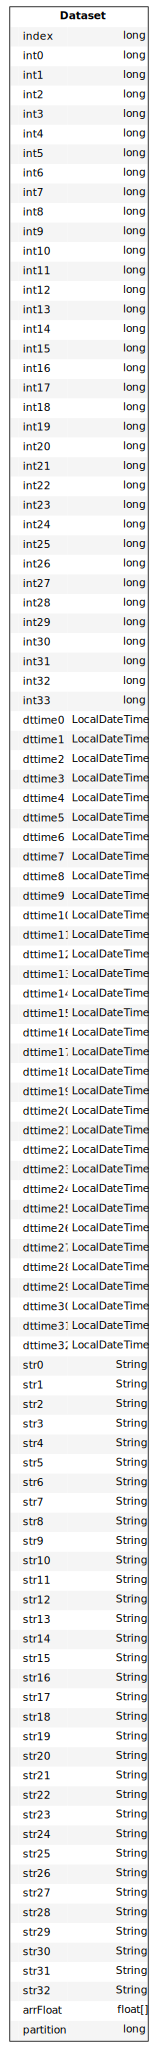

In [8]:
cube.schema

In [9]:
# Disable the aggregate cache
cube.aggregates_cache.capacity = -1

In [10]:
# Define vector aggregation and value at risk
h, m, l = cube.hierarchies, cube.measures, cube.levels

m["PnlVector"] = atoti.agg.sum(dataset["arrFloat"])
m["ValueAtRisk"] = atoti.array.quantile(m["PnlVector"], q=0.95)

In [11]:
# Create a hierarchy to access vector elements
cube.create_parameter_hierarchy_from_members("Scenarios", list(range(0, 1000)))
m["PnL at index"] = m["PnlVector"][l["Scenarios"]]

Creating hierarchies for numerical columns required for querying.

In [12]:
h["int10"] = [dataset["int10"]]
h["int11"] = [dataset["int11"]]
h["int12"] = [dataset["int12"]]
h["int13"] = [dataset["int13"]]

In [13]:
session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

In [14]:
# Number of facts in the cube
cube.query(m["contributors.COUNT"])

,contributors.COUNT
0,"1,720,000"


### Query Benchmark

In [15]:
def Q1():
    return cube.query(m["ValueAtRisk"], levels=[l["str0"]], mode="raw")


def Q2():
    return cube.query(
        m["ValueAtRisk"],
        levels=[
            l["str0"],
            l["str1"],
            l["int10"],
            l["int11"],
            l["dttime10"],
            l["dttime11"],
        ],
        mode="raw",
    )


def Q3():
    return cube.query(
        m["ValueAtRisk"],
        levels=[
            l["str0"],
            l["str1"],
            l["str2"],
            l["str3"],
            l["int10"],
            l["int11"],
            l["int12"],
            l["int13"],
            l["dttime10"],
            l["dttime11"],
            l["dttime12"],
            l["dttime13"],
        ],
        mode="raw",
    )


def Q4():
    return cube.query(
        m["PnL at index"],
        levels=[l["str0"], l["Scenarios"]],
        condition=(l["str1"] == "KzORBHFRuFFOQm"),
        mode="raw",
    )


# Iterations
iterations = 10


def benchmark(name, task):
    # Warmup
    for w in range(10):
        task()

    start = time.time()
    for i in range(iterations):
        task()
    elapsed = time.time() - start

    print(f"{name} average query time {round(1000*elapsed/iterations)} ms")

In [16]:
benchmark("Q1", Q1)

Q1 average query time 1364 ms


In [17]:
benchmark("Q2", Q2)

Q2 average query time 2059 ms


In [18]:
benchmark("Q3", Q3)

Q3 average query time 2275 ms


In [19]:
benchmark("Q4", Q4)

Q4 average query time 145 ms


### Launch queries manually

In [20]:
%%time
Q1()

Wall time: 1.78 s


,str0,ValueAtRisk
0,RjkOKyZO,1.003705e+10
1,rsCxKOikhShyzLDiJ,8.498596e+09
2,MPmtrSlg,1.086253e+10
3,LrCFQPSYwfu,9.240199e+09
4,rhJMSjYSCzlX,1.200207e+10
...,...,...
95,BNgqeo,9.222387e+09
96,HPPwhjrbcc,8.856503e+09
97,yagzJHsCFYLTRnBfxoq,8.071971e+09
98,sWRmMfceYqtIvhHpWke,9.870137e+09


In [21]:
%%time
Q2()

Wall time: 2.42 s


,str0,str1,int10,int11,dttime10,dttime11,ValueAtRisk
0,RjkOKyZO,jtgUe,145566,319472,2033-09-23 11:56:03,2022-07-09 16:36:05,161934080.0
1,rsCxKOikhShyzLDiJ,UuTemKopZjZI,-227342,-99861,2025-10-20 08:11:00,2037-03-24 06:24:03,161037072.0
2,MPmtrSlg,BfgAegAXj,672802,-659160,2043-04-19 09:29:10,2025-01-07 19:09:09,163304672.0
3,LrCFQPSYwfu,gBDTvykvA,666654,113146,2032-02-29 04:30:21,2033-09-23 11:56:03,165611184.0
4,rhJMSjYSCzlX,lDhEwTqibnxvE,234801,62216,2027-11-01 15:52:34,2037-11-16 14:35:06,163651808.0
...,...,...,...,...,...,...,...
9995,UbYCBRAbFuUqfw,SJPwm,554408,672802,2044-12-08 23:07:23,2042-05-01 15:21:54,163556912.0
9996,DVfvVcIripWEw,fRYZHWMeVBWnsIMAEYy,320116,-891517,2027-07-10 23:23:27,2035-12-06 14:24:21,164515440.0
9997,oxYkvBdgYjSoc,TZEeZfHce,283483,-625869,2020-04-26 06:04:06,2034-03-04 00:08:04,162759584.0
9998,UuCnxsEflYg,MmSvkpoOCyTRKA,-975223,-782544,2042-07-04 14:39:57,2037-08-06 18:59:45,163338768.0


In [22]:
%%time
Q3()

Wall time: 2.33 s


,str0,str1,str2,str3,int10,int11,int12,int13,dttime10,dttime11,dttime12,dttime13,ValueAtRisk
0,RjkOKyZO,jtgUe,jFMTfRSjZwAcNDyDd,CffuGFgtJsThJv,145566,319472,-161629,-161629,2033-09-23 11:56:03,2022-07-09 16:36:05,2047-10-20 15:33:44,2037-11-19 14:02:07,161934080.0
1,rsCxKOikhShyzLDiJ,UuTemKopZjZI,tJAVjLBtOwfpCO,EzOfb,-227342,-99861,-230387,914136,2025-10-20 08:11:00,2037-03-24 06:24:03,2039-10-20 06:28:29,2037-04-07 17:00:51,161037072.0
2,MPmtrSlg,BfgAegAXj,gSzmqwUEKkSR,KzORBHFRuFFOQm,672802,-659160,545390,513123,2043-04-19 09:29:10,2025-01-07 19:09:09,2027-07-10 23:23:27,2031-08-23 07:20:00,163304672.0
3,LrCFQPSYwfu,gBDTvykvA,DxGyHGcK,TZEeZfHce,666654,113146,308554,62830,2032-02-29 04:30:21,2033-09-23 11:56:03,2031-07-21 14:32:43,2041-11-17 02:58:19,165611184.0
4,rhJMSjYSCzlX,lDhEwTqibnxvE,ehwSbwwlaoxeMjn,xOHdyAaA,234801,62216,-138909,810688,2027-11-01 15:52:34,2037-11-16 14:35:06,2037-08-06 18:59:45,2042-07-04 14:39:57,163651808.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,UbYCBRAbFuUqfw,SJPwm,NhFLOvmpbUrhT,JMWacFutDdZZA,554408,672802,-766862,-230387,2044-12-08 23:07:23,2042-05-01 15:21:54,2027-11-01 15:52:34,2041-11-17 02:58:19,163556912.0
9996,DVfvVcIripWEw,fRYZHWMeVBWnsIMAEYy,SJPwm,oictaWCvkZjP,320116,-891517,672802,933619,2027-07-10 23:23:27,2035-12-06 14:24:21,2037-04-07 17:00:51,2031-07-21 14:32:43,164515440.0
9997,oxYkvBdgYjSoc,TZEeZfHce,CffuGFgtJsThJv,LfgILt,283483,-625869,697698,-687232,2020-04-26 06:04:06,2034-03-04 00:08:04,2019-02-18 08:43:07,2037-03-24 06:24:03,162759584.0
9998,UuCnxsEflYg,MmSvkpoOCyTRKA,kyjiZouGppWl,UpdtlH,-975223,-782544,-891899,403368,2042-07-04 14:39:57,2037-08-06 18:59:45,2048-05-12 10:45:08,2029-01-23 02:19:04,163338768.0


In [23]:
%%time
Q4()

Wall time: 123 ms


,str0,Scenarios,PnL at index
0,rhJMSjYSCzlX,0,16767245.0
1,rhJMSjYSCzlX,1,81514200.0
2,rhJMSjYSCzlX,2,137182768.0
3,rhJMSjYSCzlX,3,116985824.0
4,rhJMSjYSCzlX,4,88229608.0
...,...,...,...
60995,RjkOKyZO,995,9084117.0
60996,RjkOKyZO,996,81613888.0
60997,RjkOKyZO,997,38524268.0
60998,RjkOKyZO,998,6575558.5


  
<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=var-benchmark" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="atoti" /></a></div>